# Time Series - ML Prediction

Using the dataset obtained from the Kaggle competition: https://www.kaggle.com/competitions/nuclio-dsc-str-1124

In this competition we will apply all the theoretical knowledge of Time Series and practice pandas and XGBoost with over 400 Time Series.

We need to beat the benchmark of:
- RMSE train = 2.6952017798866694
- RMSE test = 3.1366227889028027

## 1. Initialization

In [26]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('./ts_kaggle_train.csv', index_col = 0)

In [4]:
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0


In [5]:
df.shape

(14484, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   14484 non-null  object 
 1   unique_id              14484 non-null  object 
 2   city_id                14484 non-null  int64  
 3   shop_id                14484 non-null  int64  
 4   item_category_id       14484 non-null  int64  
 5   item_id                14484 non-null  int64  
 6   monthly_average_price  13262 non-null  float64
 7   monthly_sales          13756 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 1018.4+ KB


In [7]:
df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")

In [15]:
df.sort_values(["date", "unique_id"], inplace=True)

In [16]:
df

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0
...,...,...,...,...,...,...,...,...
14479,2015-10-31,7_5822,21,7,35,5822,NaN,NaN
14480,2015-10-31,7_6185,21,7,30,6185,NaN,NaN
14481,2015-10-31,7_6497,21,7,28,6497,NaN,NaN
14482,2015-10-31,7_7856,21,7,28,7856,NaN,NaN


## 2. Nulls

In [17]:
df.isnull().sum()

date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
dtype: int64

In [20]:
df["monthly_average_price"] = (
    df
    .groupby(["unique_id"])
    ["monthly_average_price"]
    .transform(
        lambda series: series.interpolate().bfill().ffill()
    )
)

In [21]:
df.isnull().sum()

date                       0
unique_id                  0
city_id                    0
shop_id                    0
item_category_id           0
item_id                    0
monthly_average_price      0
monthly_sales            728
dtype: int64

In [22]:
# Fill NAs with 0
df["monthly_sales"].fillna(0, inplace = True)

/var/folders/0k/71063_cn2ps_md8w_rmmdjqc0000gn/T/ipykernel_96389/417181274.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["monthly_sales"].fillna(0, inplace = True)


In [23]:
df.isnull().sum()

date                     0
unique_id                0
city_id                  0
shop_id                  0
item_category_id         0
item_id                  0
monthly_average_price    0
monthly_sales            0
dtype: int64

## Funciones

In [ ]:
#nombres de columnas del df
columnas_df = df.columns.tolist()

#diccionario de transformaciones de nombres
dict_sufijos_transformaciones = {1: [[(columnas_a_imputar_moda, 'imputer_moda'), (columnas_a_imputar_mediana, 'imputer_mediana'), (columnas_a_imputar_media, 'imputer_media') ,(columnas_a_imputar_otros, 'imputer_otros'), (columnas_a_imputar_cero, 'imputer_cero')], 'remainder'],
                                 2: [[(list_columnas_a_resumir_categorias_original, 'main_categories'), (columnas_a_aplicar_frecuency_encoding_original, 'frecuency_encoding'),(columnas_a_aplicar_agrupamiento_target_encoding_original, 'pre_target_encoding') ], 'remainder'],
                                 3: [[(columnas_a_aplicar_OHE_original, 'one_hot_encoding'), (columnas_a_aplicar_target_encoding_original, 'target_encoding'), (columnas_a_transformar_binarias_original, 'binaria'), (columnas_a_transformar_ordinal_original, 'ordinal')], 'remainder']}

In [ ]:
# Generamos una funcion para formar un diccionario con los nombres de las columnas actualizados con los sufijos de las transformaciones

def cambiar_nombre_columna(lista_columna, prefijo_transofmer):
    nombres_nuevas_columna = []
    for columna in lista_columna:
        nuevas_columna.append(prefijo_transofmer + '__' + columna)
    return nuevas_columna

In [ ]:
# Generamos DF de nombre original (columna), nombre_1 (sufijo_1__columna), nombre_2, etc

def genera_df_nombres_pipeline(columnas_df, dict_sufijos_transformaciones):
  df_nombres_pipeline = pd.DataFrame(columns = ['nombre_original'])
  df_nombres_pipeline['nombre_original'] = columnas_df
  df_nombres_pipeline.astype(str)
  # recorremos los step del pipeline
  for n_step, transformaciones in dict_sufijos_transformaciones.items():
    columna_df = 'nombre_' + str(n_step)
    df_nombres_pipeline[columna_df] = ''
    # recorremos las transformaciones de cada step
    for columna in transformaciones[0]:
      # aplicamos el sufijo de la tupla a las columnas de la lista
      sufijo = columna[1]
      for columna_transform in columna[0]:
        #ya tenemos el sufijo de la transformacion
        #ya tenemos uno a uno la columna que se va a aplicar esta transofmacion
        if n_step == 1:
          nuevo_nombre_columna = sufijo + '__' + columna_transform
        else:
          nombre_anterior = df_nombres_pipeline[df_nombres_pipeline['nombre_original'] == columna_transform]['nombre_' + str(n_step - 1)].values[0]
          nuevo_nombre_columna = sufijo + '__' + nombre_anterior

        #Incluimos nuevo_nombre_columna en columna_df donde nombre_original coincide con column_transform
        df_nombres_pipeline.loc[df_nombres_pipeline['nombre_original'] == columna_transform, columna_df] = nuevo_nombre_columna


    # terminadas las transformaciones aplicamos el drop o remainder a las columnas restantes
    if transformaciones[1] == 'drop':
      # eliminamos filas donde df_nombres_pipeline[columna_df] es vacio (drop columnas)
      df_nombres_pipeline = df_nombres_pipeline[df_nombres_pipeline[columna_df] != '']
    if transformaciones[1] == 'remainder':
      # aplicamos el sufijo remainder donde df_nombres_pipeline[columna_df] es vacio
      sufijo = 'remainder__'
      if n_step == 1:
        df_nombres_pipeline.loc[df_nombres_pipeline[columna_df] == '', columna_df] = sufijo + df_nombres_pipeline['nombre_original']
      else:
        df_nombres_pipeline.loc[df_nombres_pipeline[columna_df] == '', columna_df] = sufijo + df_nombres_pipeline['nombre_' + str(n_step - 1)]

  return df_nombres_pipeline

## 3. EDA

<Axes: xlabel='monthly_sales'>

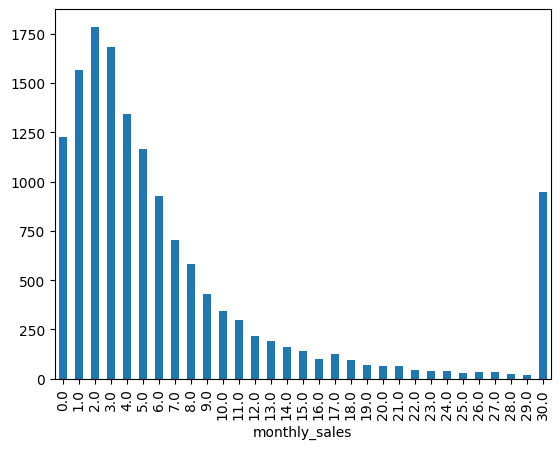

In [24]:
df["monthly_sales"].value_counts().sort_index().plot(kind = "bar")

<Axes: xlabel='shop_id'>

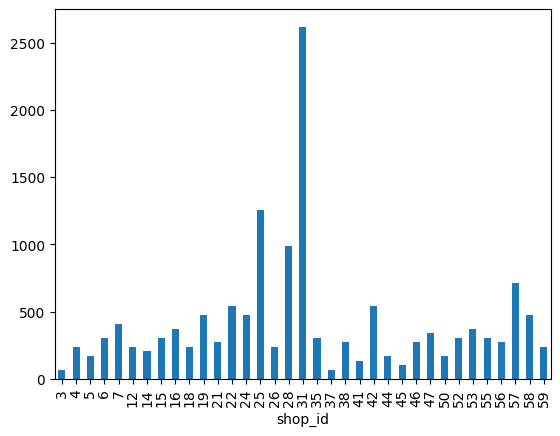

In [28]:
import seaborn as sns

df["shop_id"].value_counts().sort_index().plot(kind = "bar")

<Axes: xlabel='city_id'>

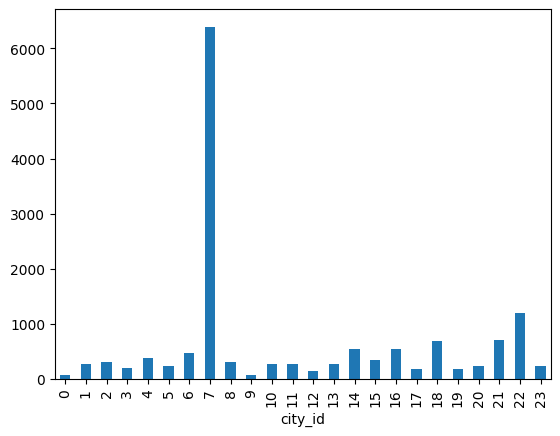

In [29]:
df["city_id"].value_counts().sort_index().plot(kind = "bar")

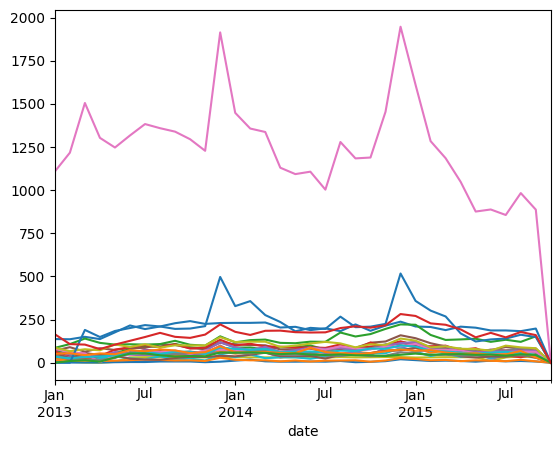

In [ ]:
for i in df.city_id.unique():
    t = (
    df[df.city_id == i]
    .groupby(["date"])
    ["monthly_sales"]
    .sum()
    )
    t.plot()

/var/folders/0k/71063_cn2ps_md8w_rmmdjqc0000gn/T/ipykernel_96389/527356016.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


<Axes: xlabel='date'>

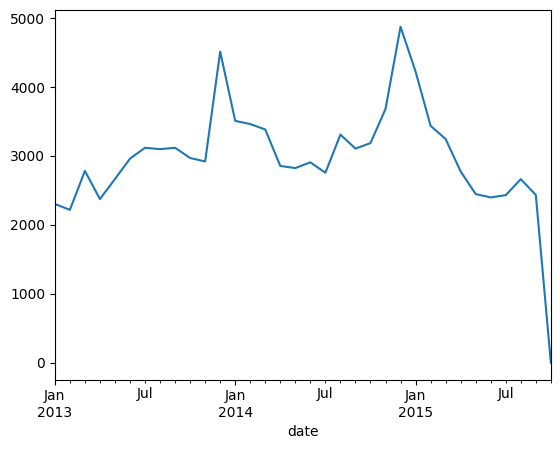

In [94]:
# resample
t = (
    df
    .set_index("date")
    .resample("M")
    ["monthly_sales"]
    .sum()
)
t.plot()

<Axes: xlabel='date'>

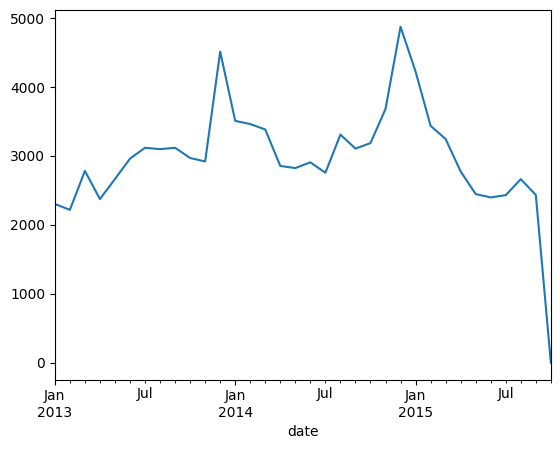

In [42]:
t = (
    df
    .groupby(["date"])
    ["monthly_sales"]
    .sum()
)
t.plot()

In [43]:
df.item_category_id.value_counts()

item_category_id
30    2924
35    2516
6     1156
40     918
55     884
71     782
65     714
28     714
23     680
79     408
75     340
49     306
73     272
2      272
63     238
19     238
64     204
31     204
9      136
83     136
54      68
69      68
21      68
41      68
22      68
57      34
38      34
76      34
Name: count, dtype: int64

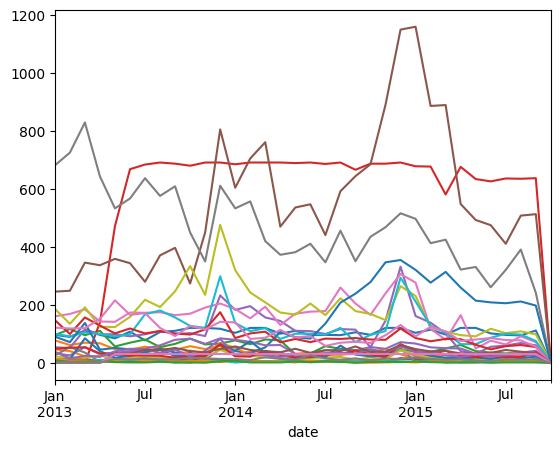

In [46]:
for i in df.item_category_id.unique():
    t = (
    df[df.item_category_id == i]
    .groupby(["date"])
    ["monthly_sales"]
    .sum()
    )
    t.plot()

<Axes: xlabel='monthly_sales', ylabel='monthly_average_price'>

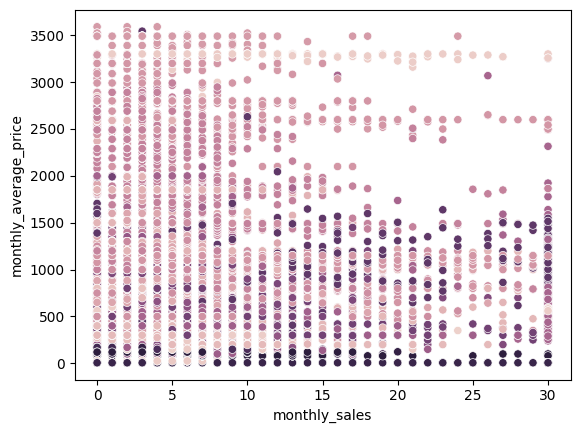

In [ ]:
sns.scatterplot(df[df["monthly_average_price"] < 4000],
                x = "monthly_sales",
                y = "monthly_average_price",
                hue = "item_id",
                legend=None)

In [78]:
df["item_category_id"].unique()

array([ 9, 49, 73, 71, 23, 35, 28, 30,  6, 65, 79,  2, 21, 55, 75, 41, 40,
       69, 64, 57, 19, 22, 38, 63, 83, 31, 76, 54])

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   14484 non-null  datetime64[ns]
 1   unique_id              14484 non-null  object        
 2   city_id                14484 non-null  int64         
 3   shop_id                14484 non-null  int64         
 4   item_category_id       14484 non-null  int64         
 5   item_id                14484 non-null  int64         
 6   monthly_average_price  14484 non-null  float64       
 7   monthly_sales          14484 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 1018.4+ KB


<Axes: xlabel='date', ylabel='monthly_sales'>

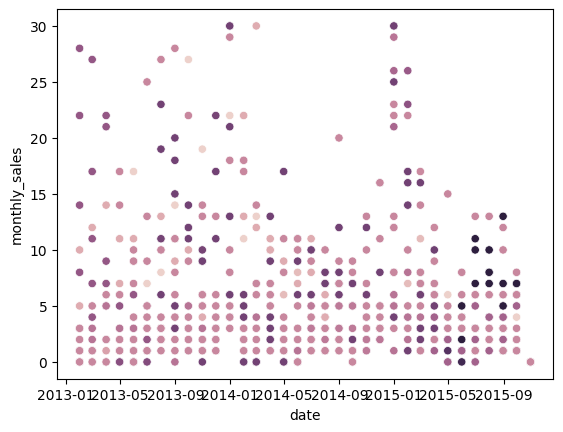

In [ ]:
list_test = pd.DataFrame(df.item_id.unique())
list_test.sample(5)
sns.scatterplot(df[df["item_category_id"] == 65],
                x = "date",
                y = "monthly_sales",
                hue = "monthly_average_price",
                legend=None)

In [ ]:
df.item_category_id

In [ ]:
df[df["monthly_average_price"] > 4000]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
56,2013-09-30,12_11365,16,12,9,11365,9305.121212,24.0


In [51]:
df[df["unique_id"] == "12_11365"]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0
35,2013-06-30,12_11365,16,12,9,11365,1302.343750,28.0
42,2013-07-31,12_11365,16,12,9,11365,1736.785714,20.0
49,2013-08-31,12_11365,16,12,9,11365,3072.361111,16.0
56,2013-09-30,12_11365,16,12,9,11365,9305.121212,24.0
63,2013-10-31,12_11365,16,12,9,11365,2493.113360,30.0


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   14484 non-null  datetime64[ns]
 1   unique_id              14484 non-null  object        
 2   city_id                14484 non-null  int64         
 3   shop_id                14484 non-null  int64         
 4   item_category_id       14484 non-null  int64         
 5   item_id                14484 non-null  int64         
 6   monthly_average_price  14484 non-null  float64       
 7   monthly_sales          14484 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 1018.4+ KB


In [ ]:
### Brainstorming de features

# Fequency Encoding - city ID / shop_id
# date
# AR: 1Y, 1D, 6M, 1M - ver como imputar nulos en los datos que nos faltan al principio de la serie
# COUNT del item por tienda - ver si un producto general o particular
# COUNT de item_id por item_category - categorias grandes vs pequeñas
# COUNT de item_id por city_id
# COUNT de shop_id por city_id
# COUNT de item_id por shop_id - tienda grande / especializada
# Grupos caros / baratos ABC
# Grupos que se venden mucho / poco

## Funciones

In [ ]:
def build_ts_features(df, gb_list, target, agg_func):
    
    new_name = "_".join(gb_list + [target] + [agg_func.__name__])
    
    gbdf = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("ME")
        [target]
        .agg(agg_func)
        .reset_index()
    )

    gbdf[f"{new_name}_shift_1"] = (
        gbdf
        .groupby(gb_list)
        [target]
        .transform(
            lambda series: series.shift(1)
        )
    )
    
    gbdf[f"{new_name}_ma_3"] = (
        gbdf
        .groupby(gb_list)
        [target]
        .transform(
            lambda series: series.shift(1).rolling(window = 3).mean()
        )
    )
    
    gbdf.drop(target, axis = 1, inplace = True)
    
    df = pd.merge(
        left = df,
        right = gbdf,
        how = "left",
        on = ["date"] + gb_list
    )
    
    return df

In [ ]:
df_back = df.copy(deep = True)
df = df_back.copy(deep = True)

In [ ]:
df = build_ts_features(
    df = df,
    gb_list =["item_category_id", "item_id"],
    target = "revenue",
    agg_func = np.sum
)

In [32]:
all_dates = sorted(df["date"].unique())

train_dates = all_dates[:-4]
test_dates = all_dates[-4:-2]
validation_dates = all_dates[-2:-1]

prediction_dates = [all_dates[-1]]

## Model

In [ ]:
def get_data_splits(df, split_dates):
    X_ = (
        df[df["date"].isin(split_dates)]
        .drop(
            ["monthly_sales", "revenue", "date"]
        , axis = 1
        ).set_index("unique_id")
    )

    y_ = df[df["date"].isin(split_dates)].set_index("unique_id")["monthly_sales"]
    
    print(split_dates)
    print(X_.shape, y_.shape)
    
    return X_, y_

X_train, y_train = get_data_splits(df=df, split_dates=train_dates)
X_test, y_test = get_data_splits(df=df, split_dates=test_dates)
X_val, y_val = get_data_splits(df=df, split_dates=validation_dates)
X_pred, y_pred = get_data_splits(df=df, split_dates=prediction_dates)

In [ ]:
import xgboost

model = xgboost.XGBRegressor(
    #max_depth = 4,
    #nr_estimators = 30
)

model.fit(
    X = X_train,
    y = y_train,
    eval_set = [(X_train, y_train), (X_test, y_test)],
    #early_stopping_rounds = 20
)

## Feature importance

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 15))
ax1, ax2, ax3 = fig.subplots(3, 1)

xgboost.plot_importance(booster = model, ax = ax1, importance_type = "gain")
xgboost.plot_importance(booster = model, ax = ax2, importance_type = "cover")
xgboost.plot_importance(booster = model, ax = ax3, importance_type = "weight")

plt.tight_layout();

## Model evaluation

In [ ]:
from sklearn.metrics import root_mean_squared_error

In [ ]:
y_train_pred = model.predict(X_train)

rmse_train = root_mean_squared_error(y_true = y_train, y_pred=y_train_pred)
rmse_train

In [ ]:
y_test_pred = model.predict(X_test)

rmse_test = root_mean_squared_error(y_true = y_test, y_pred=y_test_pred)
rmse_test